In [38]:
# Anomaly Detection in Hyperspectral Image Processing

In [39]:
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [40]:
np.random.seed(42)

In [41]:
# Generate Synthetic Hyperspectral Data
# Because real hyperspectral is hard to obtain and use

In [42]:
# Hyperspectral Image: 100x100 pixels, 200 spectral bands
n_samples = 5000
n_bands = 200

In [43]:
# Normal Spectral Signatures (Background)
normal_mean = np.linspace(0.3, 0.7, n_bands)
normal_data = np.random.normal(normal_mean, 0.1, (int(n_samples * 0.95), n_bands))

In [44]:
# Anomalous Spectral Signatures (Target)
anomaly_mean = np.linspace(0.5, 0.9, n_bands)
anomaly_data = np.random.normal(anomaly_mean, 0.15, (int(n_samples * 0.95), n_bands))

In [45]:
# Distinctive Peaks for Anomalies (Target Signatures)
anomaly_data[:, 50:60] += 0.3
anomaly_data[:, 120:130] += 0.4

In [46]:
X = np.vstack([normal_data, anomaly_data])
y = np.hstack([np.zeros(len(normal_data)), np.ones(len(anomaly_data))])

In [47]:
shuffle_idx = np.random.permutation(len(X))
X = X[shuffle_idx]
y = y[shuffle_idx]

In [48]:
print(f"Total samples: {len(X)}")
print(f"Normal samples: {np.sum(y == 0)} ({np.sum(y == 0)/len(y)*100:.1f}%)")
print(f"Anomalous samples: {np.sum(y == 1)} ({np.sum(y == 1)/len(y)*100:.1f}%)")
print(f"Spectral bands: {n_bands}")

Total samples: 9500
Normal samples: 4750 (50.0%)
Anomalous samples: 4750 (50.0%)
Spectral bands: 200


In [49]:
# Data Preprocessing

In [50]:
# Split data
train_size = int(0.7 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [51]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [52]:
print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

Training set: 6650 samples
Test set: 2850 samples


In [53]:
# Dimensionality Reduction (PCA)

In [54]:
pca = PCA(n_components = 0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Original dimensions: {X_train_scaled.shape[1]}")
print(f"Reduced dimensions: {X_train_pca.shape[1]}")
print(f"Explained variance: {pca.explained_variance_ratio_.sum() * 100:.2f}%")

Original dimensions: 200
Reduced dimensions: 166
Explained variance: 95.08%


In [55]:
# One Class SVM - Unsupervised Anomaly

In [56]:
X_train_normal = X_train_pca[y_train == 0]

svm_model = OneClassSVM(kernel = 'rbf', gamma = 'auto', nu = 0.1)
svm_model.fit(X_train_normal)

svm_pred_train = svm_model.predict(X_train_pca)
svm_pred_test = svm_model.predict(X_test_pca)

svm_pred_train = np.where(svm_pred_train == -1, 1, 0)
svm_pred_test = np.where(svm_pred_test == -1, 1, 0)

print("\nOne-Class SVM Results:")
print("\nTest Set Performance:")
print(classification_report(y_test, svm_pred_test, target_names = ['Normal', 'Anomaly']))


One-Class SVM Results:

Test Set Performance:
              precision    recall  f1-score   support

      Normal       1.00      0.92      0.96      1438
     Anomaly       0.93      1.00      0.96      1412

    accuracy                           0.96      2850
   macro avg       0.96      0.96      0.96      2850
weighted avg       0.96      0.96      0.96      2850



In [57]:
# Isolation Forest

In [58]:
iso_model = IsolationForest(contamination = 0.05, random_state = 42)
iso_model.fit(X_train_pca)

iso_pred_train = iso_model.predict(X_train_pca)
iso_pred_test = iso_model.predict(X_test_pca)

iso_pred_train = np.where(iso_pred_train == -1, 1, 0)
iso_pred_test = np.where(iso_pred_test == -1, 1, 0)

print("Isolation Forest Results:")
print("\nTest Set Performance:")
print(classification_report(y_test, iso_pred_test, target_names = ['Normal', 'Anomaly']))

Isolation Forest Results:

Test Set Performance:
              precision    recall  f1-score   support

      Normal       0.53      1.00      0.70      1438
     Anomaly       1.00      0.11      0.20      1412

    accuracy                           0.56      2850
   macro avg       0.77      0.56      0.45      2850
weighted avg       0.77      0.56      0.45      2850



In [59]:
# Random Forest Classifier - Supervised

In [60]:
rf_model = RandomForestClassifier(n_estimators = 100, max_depth = 10, random_state = 42)
rf_model.fit(X_train_pca, y_train)

rf_pred_train = rf_model.predict(X_train_pca)
rf_pred_test = rf_model.predict(X_test_pca)

print("Random Forest Classifier Results:")
print("\nTest Set Performance:")
print(classification_report(y_test, rf_pred_test, target_names = ['Normal', 'Anomaly']))

Random Forest Classifier Results:

Test Set Performance:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      1438
     Anomaly       1.00      1.00      1.00      1412

    accuracy                           1.00      2850
   macro avg       1.00      1.00      1.00      2850
weighted avg       1.00      1.00      1.00      2850



In [61]:
# Plotting

Text(0.5, 1.0, 'Random Forest Confusion Matrix')

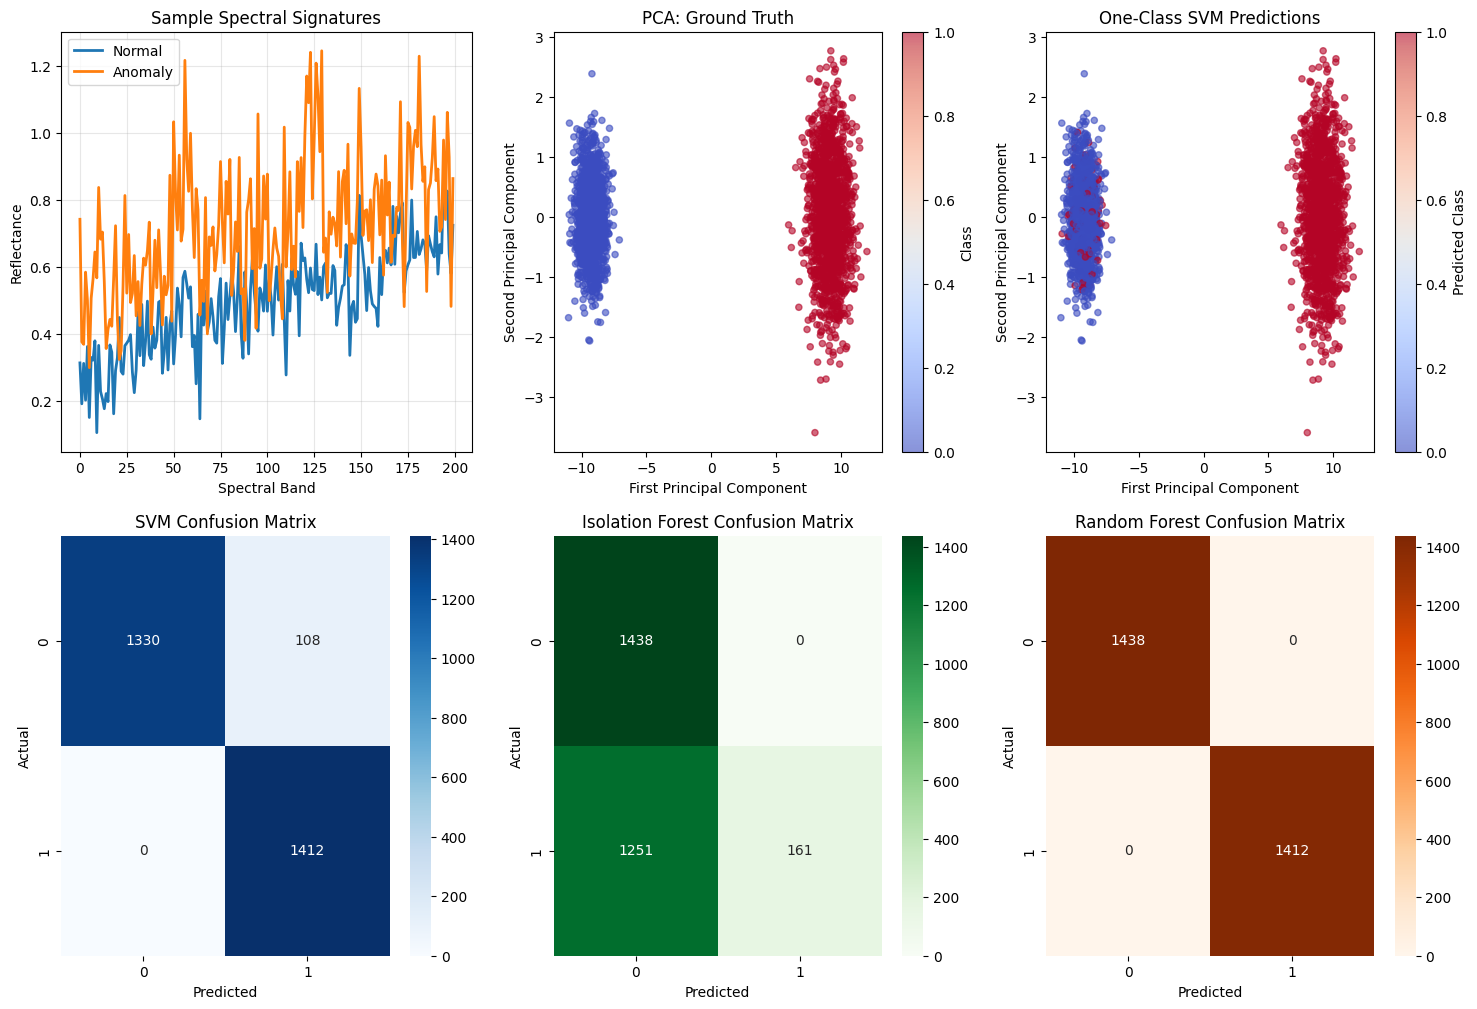

In [62]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Sample spectral signatures
ax = axes[0, 0]
normal_idx = np.where(y_test == 0)[0][0]
anomaly_idx = np.where(y_test == 1)[0][0]
ax.plot(X_test[normal_idx], label = 'Normal', linewidth = 2)
ax.plot(X_test[anomaly_idx], label = 'Anomaly', linewidth = 2)
ax.set_xlabel('Spectral Band')
ax.set_ylabel('Reflectance')
ax.set_title('Sample Spectral Signatures')
ax.legend()
ax.grid(True, alpha = 0.3)

# PCA
ax = axes[0, 1]
scatter = ax.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c = y_test, cmap = 'coolwarm', alpha = 0.6, s = 20)
ax.set_xlabel('First Principal Component')
ax.set_ylabel('Second Principal Component')
ax.set_title('PCA: Ground Truth')
plt.colorbar(scatter, ax = ax, label = 'Class')

# SVM
ax = axes[0, 2]
scatter = ax.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c = svm_pred_test, cmap = 'coolwarm', alpha = 0.6, s = 20)
ax.set_xlabel('First Principal Component')
ax.set_ylabel('Second Principal Component')
ax.set_title('One-Class SVM Predictions')
plt.colorbar(scatter, ax=ax, label='Predicted Class')

# Confusion matrix - SVM
ax = axes[1, 0]
cm_svm = confusion_matrix(y_test, svm_pred_test)
sns.heatmap(cm_svm, annot = True, fmt = 'd', cmap = 'Blues', ax = ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('SVM Confusion Matrix')

# Confusion matrix - Isolation Forest
ax = axes[1, 1]
cm_iso = confusion_matrix(y_test, iso_pred_test)
sns.heatmap(cm_iso, annot = True, fmt = 'd', cmap = 'Greens', ax = ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Isolation Forest Confusion Matrix')

# Confusion matrix - Random Forest
ax = axes[1, 2]
cm_rf = confusion_matrix(y_test, rf_pred_test)
sns.heatmap(cm_rf, annot = True, fmt = 'd', cmap = 'Oranges', ax = ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Random Forest Confusion Matrix')


In [63]:
plt.tight_layout()
plt.savefig('hyperspectral.png', dpi = 300, bbox_inches = 'tight')
print("Visualization saved as 'hyperspectral.png'")
plt.show()

Visualization saved as 'hyperspectral.png'


<Figure size 640x480 with 0 Axes>

In [64]:
# Comparison

In [65]:
models = ['One-Class SVM', 'Isolation Forest', 'Random Forest']
predictions = [svm_pred_test, iso_pred_test, rf_pred_test]

In [66]:
results = []
for model_name, pred in zip(models, predictions):
    acc = accuracy_score(y_test, pred)
    prec = precision_score(y_test, pred)
    rec = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    results.append([model_name, acc, prec, rec, f1])

In [67]:
print(f"\n{'Model':<20} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
for r in results:
    print(f"{r[0]:<20} {r[1]:<12.4f} {r[2]:<12.4f} {r[3]:<12.4f} {r[4]:<12.4f}")


Model                Accuracy     Precision    Recall       F1-Score    
One-Class SVM        0.9621       0.9289       1.0000       0.9632      
Isolation Forest     0.5611       1.0000       0.1140       0.2047      
Random Forest        1.0000       1.0000       1.0000       1.0000      


In [68]:
# Conclusion

# Use Random Forest when you have labeled training data
# Use Isolation Forest for initial exploration
# Apply PCA to reduce computational cost
# Consider ensemble methods combining multiple approaches